# Prototype Dataset
This file generates the path-to-path dataset to train a prototype transformer

The input output sequence of a logo should consist of 270 Parameters
- DeepSVG Embedding (256)
- a0 Type "EOS" (1)
- a1 - a6 Type (6)
- a7 - a12 Param (6)
- a13 time offset from beginning of animation in seconds

Input Sequence
- In the input sequence, the last 13 Parameters are set to zero
- In a final model, these parameters are aimed to be left out (as context vector isn't based on that)

Output Sequence
- The Output sequence consists of the selected paths represented by their DeepSVG Embedding
- The Animation is represented through the type and the parameters.
- Each output sequence ends with an EOS Token, where the EOS-type in the one-hot-encoded part is set to 1.

## Creating the input data

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

file_path = 'data/5_svg_embedding/svg_embedding_5000.pkl'

# Open the pickle file for reading in binary mode
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

#filtered_data = pd.read_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";").rename(columns={"filename":"file", "rating" : "label"})
#data["filename"]=data["filename"].str.replace(".svg","")
#test = pd.merge(data, filtered_data, left_on="filename", right_on="file", how="inner")

print(data)

   animation_id         0         1         2         3         4         5  \
0             0 -1.479738  1.499942 -0.460764  0.363093 -0.947988 -1.115443   
1             1 -0.198556  0.946851  0.497889 -0.779701 -0.070278 -0.871111   
2             3  0.141129  1.822560  0.397646  0.658561 -1.421428 -1.602260   
3             2  0.989437  0.265804  2.549353  0.695821 -0.884729 -0.079115   
4             5 -0.157587  0.536932  0.361361 -0.021343 -0.385152  0.616863   
..          ...       ...       ...       ...       ...       ...       ...   
4             6 -0.187661  0.401433 -0.100404  0.636203 -0.474901  1.383271   
5             7  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   
6             5 -0.833903  0.496440  0.277829  0.364739 -1.040107  0.297266   
7             4 -0.400199  0.921548  0.191972  0.333160 -1.018423 -1.097480   
8             8  0.877559 -1.188825  1.372045 -0.126786 -0.186506 -0.021710   

           6         7         8  ...       247    

In [2]:
# checking the number of paths 

data['filename'].value_counts()
data["filename"]=data["filename"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\3690324963.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data["filename"]=data["filename"].str.replace(".svg","")


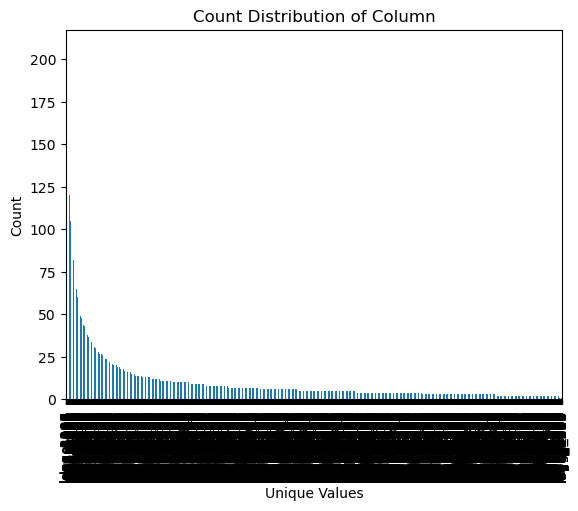

In [3]:
count_distribution = data['filename'].value_counts()
count_distribution.plot(kind='bar')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

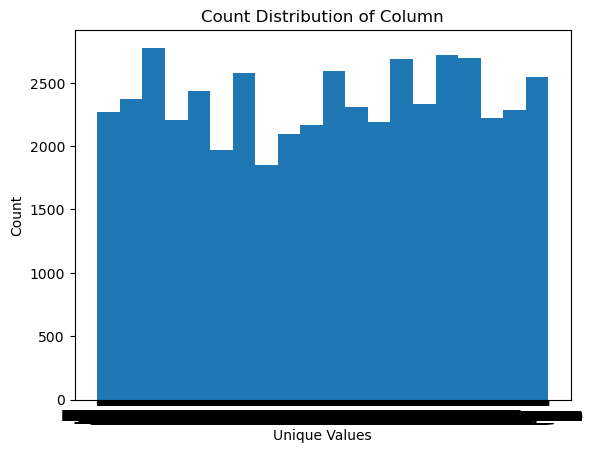

In [4]:
plt.hist(data['filename'], bins=20)  # You can adjust the number of bins as needed
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Count Distribution of Column')
plt.show()

In [5]:
# max number of paths in one logo
data['filename'].value_counts().iloc[0]

207

In [6]:
data[data['filename']=='logo_36']

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_36
1,1,-0.046564,1.268721,0.179297,0.520527,0.102936,0.511308,0.318602,0.652480,-0.204564,...,0.470238,-0.319376,0.230528,0.867940,0.395773,1.336052,0.325830,0.626101,-0.292177,logo_36
2,3,0.078027,-0.885305,0.575409,0.644550,0.071136,1.975846,-0.815557,-0.023037,-0.983261,...,-2.104513,0.376560,1.087818,1.251735,-0.982731,-0.423921,0.295719,-0.759669,-0.560176,logo_36
3,2,0.298474,-1.835696,0.278614,-0.592662,0.103240,0.527570,-0.301879,-0.378880,-0.419961,...,-3.453290,-0.456308,1.361012,0.638535,-0.515345,0.179005,0.714492,-0.504355,-0.210751,logo_36
4,4,0.043930,0.052075,-0.245103,0.936828,-0.281573,1.871222,-1.050934,0.586057,-0.180195,...,-0.875970,-0.431099,0.048782,1.273455,0.410215,-0.542904,0.352429,-1.753664,-0.421086,logo_36


In [7]:
#type(data['animation_id'][118])

In [8]:
# Read CSV into DataFrame
df = pd.read_csv('data/ratings/test_rating.csv')

df['id'] = df.index

# separating to rating and animation
animation_df = df[['id','filename','data', "rating"]]

rating_df = df[['id','filename','rating']]


In [9]:
animation_df

,id,filename,data,rating
0,0,logo_0.svg,"0,0,0,1,0,0,0,0,0,0,0,0,2,-9,17,22,43,0,0,0,0,...",4
1,1,logo_3555.svg,"4,0,1,0,0,0,0,0,0,0,0,1,1,20,-28,16,17,16.4101...",0
2,2,logo_4597.svg,"70,0,0,0,0,0,0,0,0,0,1,0,2,-42,11,-36,4,0.0770...",0
3,3,logo_975.svg,"5,0,0,1,0,0,0,0,0,0,0,3,2,34,42,12,-1,0,0,0,0,...",0
4,4,logo_3578.svg,"2,0,0,0,0,0,0,0,1,0,0,0,5,2,-11,-16,-34,3.3476...",0
...,...,...,...,...
1547,1547,logo_3952.svg,NaN,0
1548,1548,logo_970.svg,"0,0,0,0,0,0,0,0,0,0,1,0,4,45,34,-38,28,8.28508...",0
1549,1549,logo_4944.svg,"0,0,0,0,1,0,0,0,0,0,0,0,3,-44,44,-13,-36,9.192...",0
1550,1550,logo_149.svg,"6,0,0,1,0,0,0,0,0,0,0,0,1,-6,21,17,-45,0,0,0,0...",0


In [10]:
# changing the structure of rating data 

# Split the 'data' column and explode
animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')
animation_df = animation_df.explode('data').dropna()

# Reset the index
animation_df.reset_index(drop=True, inplace=True)

# separating the animation ids and animation params
animation_df[['animation_id','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df['data'].str.split(',', expand=True)

animation_df[['animation_id']] = animation_df[['animation_id']].astype(int)

animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].astype(float)

# Create a new column with concatenated values from each row
animation_df['model_output'] = animation_df[['a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25']].apply(lambda row: list(row), axis=1)

animation_df.drop(columns=['data','a_0','a_1','a_2','a_3','a_4','a_5','a_6','a_7','a_8','a_9',
           'a_10','a_11','a_12','a_13','a_14','a_15','a_16','a_17','a_18','a_19','a_20','a_21',
           'a_22','a_23','a_24','a_25'], inplace=True)

animation_df.to_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";")
animation_df["model_output"] = list(animation_df["model_output"])
animation_df["model_output"]

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\3409916436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  animation_df['data'] = animation_df['data'].str.rstrip(';').str.split(';')


0        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
3        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
56964    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
56965    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
56966    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
56967    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
56968    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: model_output, Length: 56969, dtype: object

## PROTOTYPE DATASET START

## Import DeepSVG Embedding

In [11]:
import pickle

import torch

with open("data/5_svg_embedding/svg_embedding_5000.pkl", "rb") as f:
    deepsvg_embedding = pickle.load(f)
deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\3921990055.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  deepsvg_embedding["filename"] = deepsvg_embedding["filename"].str.replace(".svg","")


In [12]:
## duplicate for further use
embeddings = deepsvg_embedding.copy() #for output sequences
input_sequences = deepsvg_embedding

In [13]:
embeddings['animation_id'] = embeddings['animation_id'].astype(int)
embeddings.head()

,animation_id,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,filename
0,0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,1.581553,-0.411030,0.169418,...,1.718861,-0.139440,-1.523274,-1.602520,0.121773,-0.331636,1.083312,1.555735,0.406794,logo_2860
1,1,-0.198556,0.946851,0.497889,-0.779701,-0.070278,-0.871111,0.403914,1.100798,-0.337577,...,-2.135782,0.779249,-0.337505,0.429479,-0.411051,2.071597,-0.557817,0.053835,-0.110260,logo_2860
2,3,0.141129,1.822560,0.397646,0.658561,-1.421428,-1.602260,0.216757,0.756272,-1.212852,...,-1.516084,-1.266155,-1.031826,-0.137128,-0.715295,-1.437720,-0.900047,1.734579,2.157370,logo_2860
3,2,0.989437,0.265804,2.549353,0.695821,-0.884729,-0.079115,0.200200,0.758520,-1.034283,...,0.970688,-0.900468,-0.504259,-0.915307,-0.481459,0.234924,-1.022180,1.685095,0.882979,logo_2860
4,5,-0.157587,0.536932,0.361361,-0.021343,-0.385152,0.616863,-0.865314,0.770734,-0.353508,...,-1.172260,0.180234,-0.066151,1.415687,-0.415280,-0.704430,1.124239,-0.776726,0.313482,logo_2860


## Train / Test Split

### Logo Dataset Analysis
Most logos have only a few paths
Some logos have over 100 paths to animate

In [14]:
# Might not execute
# input_sequences['filename'].value_counts().hist(bins=100)

### Stratify on Number of Paths in Logo

In [15]:
# Count occurrences
logos = input_sequences.groupby('filename').size().reset_index(name='count')

# To stratify later, categorize the sizes
bins = 20
quantiles = [(i+1)/bins for i in range(bins)]
print(quantiles)

percentiles = logos['count'].quantile(quantiles)
print(percentiles)

# Function to categorize based on quantiles
def categorize_count(count):
    for i, percentile in enumerate(percentiles):
        if count <= percentile:
            return f"Quantile {i}"
    return f"Quantile {len(quantiles)}"

# Apply the categorization function to create a new column
logos['count_category'] = logos['count'].apply(categorize_count)
logos['count_category'].value_counts()

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
0.05      2.0
0.10      2.0
0.15      3.0
0.20      3.0
0.25      3.0
0.30      4.0
0.35      4.0
0.40      4.0
0.45      5.0
0.50      5.0
0.55      6.0
0.60      6.0
0.65      7.0
0.70      8.0
0.75      9.0
0.80     11.0
0.85     14.0
0.90     20.0
0.95     35.0
1.00    207.0
Name: count, dtype: float64


Quantile 2     686
Quantile 5     621
Quantile 0     615
Quantile 8     514
Quantile 10    370
Quantile 12    295
Quantile 15    272
Quantile 16    225
Quantile 19    225
Quantile 13    222
Quantile 17    211
Quantile 18    209
Quantile 14    137
Name: count_category, dtype: int64

### Train / Test split

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the DataFrame into training and testing sets, stratifying on 'count_category'
logos_train, logos_test = train_test_split(logos, test_size=0.2, stratify=logos['count_category'], random_state=42)

The distributions of lenghts are now similar. Outliers with a long sequence are in both datasets

<Axes: >

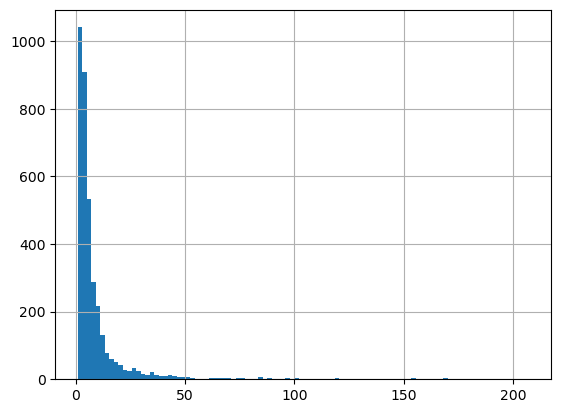

In [17]:
logos_train['count'].hist(bins=100)

<Axes: >

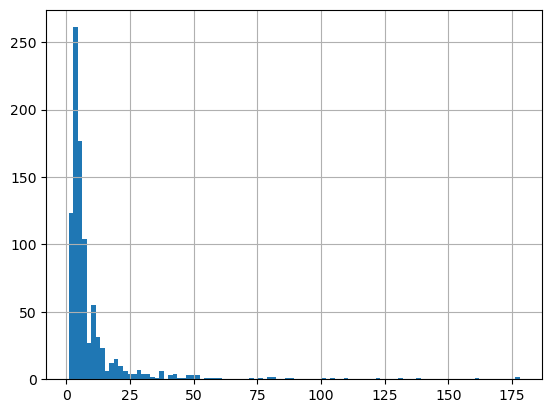

In [18]:
logos_test['count'].hist(bins=100)

In [19]:
logos_test = logos_test['filename'].unique()
logos_train = logos_train['filename'].unique()
logos_test

array(['logo_2889', 'logo_4324', 'logo_566', 'logo_2659', 'logo_2077',
       'logo_285', 'logo_3528', 'logo_764', 'logo_4486', 'logo_2306',
       'logo_3748', 'logo_2267', 'logo_4250', 'logo_4814', 'logo_2917',
       'logo_4154', 'logo_3066', 'logo_844', 'logo_2966', 'logo_2383',
       'logo_3328', 'logo_1517', 'logo_629', 'logo_3261', 'logo_3700',
       'logo_813', 'logo_4370', 'logo_1541', 'logo_4714', 'logo_3210',
       'logo_2539', 'logo_4114', 'logo_4496', 'logo_1286', 'logo_1394',
       'logo_3577', 'logo_690', 'logo_4124', 'logo_504', 'logo_3832',
       'logo_2800', 'logo_3947', 'logo_1139', 'logo_4334', 'logo_2862',
       'logo_2384', 'logo_554', 'logo_4568', 'logo_1631', 'logo_3631',
       'logo_1918', 'logo_4586', 'logo_2895', 'logo_1090', 'logo_4748',
       'logo_3606', 'logo_4189', 'logo_2228', 'logo_777', 'logo_1356',
       'logo_3353', 'logo_461', 'logo_2229', 'logo_1783', 'logo_4738',
       'logo_996', 'logo_4861', 'logo_2148', 'logo_1418', 'logo_4546',
    

### Discussion
- One might also stratify over used animation types.
- Are there enough good animations in the dataset for logos with lots of paths? -> Manual annotation

## Animation Dataset

In [20]:
import pickle
import pandas as pd

# Load the pickle file
with open("data/surrogate_model/animation_label.pkl", "rb") as f:
    imported_pickle = pickle.load(f)

# Create a DataFrame from the imported data
filtered_data = pd.DataFrame(imported_pickle, columns=["file", "animation_id", "model_output", "label"])

filtered_data = pd.read_csv("data/animated_svgs_dataframes/firebase_animations.csv", sep=";").rename(columns={"filename":"file", "rating" : "label"})

# Define the mapping for ratings
#mapping_dict = {"Very Good": 6, "Good": 5, "Okay": 4, "Bad": 3, "Very Bad": 2, "no_rating": 1}
# Replace the 'label' column with the corresponding ratings using .map
#filtered_data['rating'] = filtered_data['label'].map(mapping_dict)
filtered_data['rating'] = filtered_data['label']

filtered_data["file"] = filtered_data["file"].str.replace(".svg","")
# Extract unique logos by splitting 'file' with "_animation" and using .str.get(0)
#logos_unique = filtered_data['file'].str.split('_animation').str.get(0).unique()

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\2354969405.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  filtered_data["file"] = filtered_data["file"].str.replace(".svg","")


In [21]:
#example
filtered_data[filtered_data["file"].str.contains("logo_5")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
1796,1796,41,logo_52,3,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2091,2091,107,logo_535,0,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
2092,2092,107,logo_535,0,3,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2093,2093,107,logo_535,0,10,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
2094,2094,107,logo_535,0,19,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...
55462,55462,1398,logo_530,4,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
55463,55463,1398,logo_530,4,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
55923,55923,1409,logo_566,4,0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
56021,56021,1424,logo_560,4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4


### Consistency: Delete twice animated paths in one animation
Every animation should animate each path only once. **But there are duplicates.**
Some duplicates are completely equal.

In [22]:
# Example
filtered_data[filtered_data['file'] == "logo_379_animation_5"]
filtered_data.head()

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
1,1,0,logo_0,4,3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
2,2,0,logo_0,4,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4
3,3,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,4,1,logo_3555,0,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [23]:
# SIMPLE DUPLICATE REDUCTION
print(f"There are {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

# Create a copy for and convert numpy to strings
duplicate_search = filtered_data.copy()
duplicate_search['model_output'] = duplicate_search['model_output'].apply(lambda x: str(x))

# Find duplicates in the copy and remove with a mask
duplicates_mask = duplicate_search.duplicated(keep='first')
filtered_data = filtered_data[~duplicates_mask]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

There are 52436 duplicates.
Reduced to 52436 duplicates.


But there are some more duplicates. Some have different ratings, so let's simply keep the better rating:

In [24]:
duplicates_mask = filtered_data.duplicated(subset=['file', 'animation_id'], keep=False)
filtered_data[duplicates_mask]

,Unnamed: 0,id,file,label,animation_id,model_output,rating
0,0,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
3,3,0,logo_0,4,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4
4,4,1,logo_3555,0,4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
7,7,1,logo_3555,0,32,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
8,8,1,logo_3555,0,26,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...
56961,56961,1550,logo_149,0,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
56963,56963,1551,logo_3066,2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2
56964,56964,1551,logo_3066,2,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",2
56965,56965,1551,logo_3066,2,2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [25]:
# Sort the DataFrame by 'file', 'animation_id' (for grouping) and 'rating' (descending order to prioritize higher ratings)
filtered_data_sorted = filtered_data.sort_values(by=['file', 'animation_id', 'rating'], ascending=[True, True, False])

# Mark duplicates, keeping the row with the highest rating
duplicates_mask = filtered_data_sorted.duplicated(subset=['file', 'animation_id'], keep='first')

# Identify the indices of rows to keep and filter the original DataFrame
indices_to_keep = filtered_data_sorted[~duplicates_mask].index

filtered_data = filtered_data.loc[filtered_data.index.intersection(indices_to_keep)]

print(f"Reduced to {filtered_data.duplicated(subset=['file', 'animation_id'], keep=False).sum()} duplicates.")

Reduced to 0 duplicates.


Now all duplicates are gone. Let's check with an example:

In [26]:
# Check: Should be 7 animations instead of 14 
filtered_data[filtered_data['file'] == "logo_379"]  # EG: logo_379_animation_5 , logo_334_animation_12

,Unnamed: 0,id,file,label,animation_id,model_output,rating


In [27]:
filtered_data.reset_index(drop=True, inplace=True)

### Some Statistics about the Animations we have here
Result: Many animations with only one animated path

In [28]:
grouped = filtered_data.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations initially")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

1259 Animations initially
    Animation Length  Count
0                  1    380
1                  2    248
2                  3    156
3                  4    108
4                  5     71
..               ...    ...
57               290      1
49               302      1
40               391      1
48               444      1
56               671      1

[67 rows x 2 columns]


In [29]:
grouped = filtered_data.groupby('label').count()
grouped = grouped[['file']].reset_index()
grouped.columns = ['Rating', 'Count']
grouped['Percentage'] = (grouped['Count'] / grouped['Count'].sum()) * 100
grouped

,Rating,Count,Percentage
0,0,5043,48.198413
1,1,2544,24.314250
2,2,1677,16.027908
3,3,899,8.592182
4,4,300,2.867246


### Investigate overall rating of animations

<Axes: >

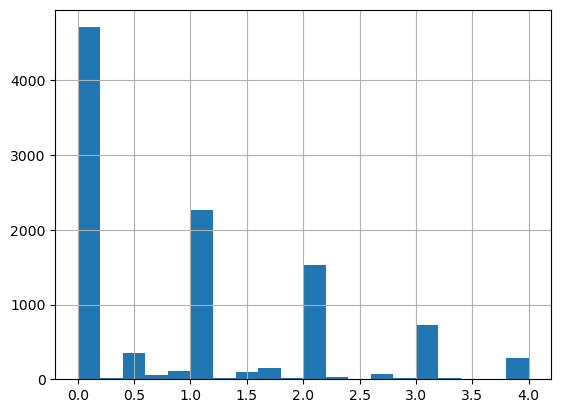

In [30]:
filtered_data['average_rating'] = filtered_data.groupby('file')['rating'].transform('mean')
filtered_data['average_rating'].hist(bins=20)

In [31]:
# example
filtered_data[filtered_data["file"].str.contains("logo_5_")]

,Unnamed: 0,id,file,label,animation_id,model_output,rating,average_rating


### Now pick good Animations only
Pick the following animations
- Best per logo (include as many different logos as possible)
- Add all GOOD animations (additionally add as many animations as possible) TODO: Implement later

In [32]:
filtered_data['include'] = 0

In [33]:
# use all animations with an average rating over 3
minimum_rating = 2
temp = filtered_data['average_rating'] > minimum_rating
filtered_data.loc[temp, 'include'] = 1

In [34]:
print(f"{filtered_data['include'].mean() * 100}% of the data is left out")

11.105801395393291% of the data is left out


In [35]:
# go through each logo to find the best animation
for logo in logos:
    # make a data frame that contains all the animations of one logo
    temp = filtered_data[filtered_data["file"].str.contains(logo)]

    best_logo = temp[temp['average_rating'] == temp['average_rating'].max()]
    best_logo = best_logo['file'].unique()
    
    filtered_data.loc[filtered_data['file'].isin(best_logo), 'include'] = 1
    break

In [36]:
print(f"Now {filtered_data['include'].mean() * 100}% of the data is left out")

Now 11.105801395393291% of the data is left out


Note: No additional animations are selected

In [37]:
best_output = filtered_data[filtered_data['include'] == 1].copy()
best_output.drop(columns=['include'], inplace=True, axis=1)

In [38]:
# extract logo
pattern = r'(logo_\d+)'
best_output['filename'] = best_output['file'].str.extract(pattern)

### Numeration to keep order later (corresponds to start-time)

In [39]:
# # Create a time_offset column filled with zeros
# best_output['a13'] = 0.0

# # Define animation start time offset in seconds from animation start
# TIME_OFFSET_STEP = 0.25

# # Initialize a dictionary to store numbering for each file
# file_counts = {}

# # Iterate through the "file" column and number each unique file
# for index, row in best_output.iterrows():
#     filename = row['file']
#     if filename not in file_counts:
#         file_counts[filename] = 1
#     else:
#         file_counts[filename] += 1
#     best_output.at[index, 'a13'] = file_counts[filename] * TIME_OFFSET_STEP
# best_output.head()

### Stat: Animated paths per logo

In [40]:
used_paths = best_output[["filename", "animation_id"]].drop_duplicates(
    subset = ['filename', 'animation_id'], keep = 'last').reset_index(drop = True)
used_paths.head()

,filename,animation_id
0,logo_0,0
1,logo_0,3
2,logo_0,2
3,logo_1509,1
4,logo_1509,6


array([[<Axes: title={'center': 'animation_id'}>]], dtype=object)

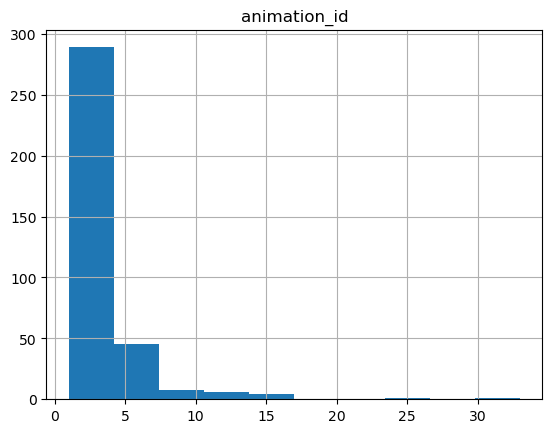

In [41]:
used_paths.groupby(['filename']).count().hist()

### Some Statistics again


In [42]:
grouped = best_output.groupby('file').count()
grouped = grouped[['animation_id']]
print(f"{grouped.size} Animations left over")
histogram_table = grouped['animation_id'].value_counts().reset_index()
histogram_table.columns = ['Animation Length', 'Count']
histogram_table = histogram_table.sort_values(by='Animation Length')
print(histogram_table)

354 Animations left over
    Animation Length  Count
0                  1     93
1                  2     79
2                  3     71
3                  4     46
4                  5     20
5                  6     15
6                  7     10
8                  8      3
10                 9      2
9                 10      3
7                 11      6
11                14      2
14                15      1
15                16      1
13                24      1
12                33      1


# Build sequences

## Make List of all Data Samples

### Apply Stats

In [43]:
final_animation_stats = best_output[['filename', 'file', 'model_output']].copy()
final_animation_stats['animation_length'] = 1
for i in range(26):
 final_animation_stats[f'a{i}'] = final_animation_stats['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
final_animation_stats.drop(['model_output'], inplace=True, axis=1)
final_animation_stats

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,logo_0,logo_0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,logo_0,logo_0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,logo_0,logo_0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,16.888462,18.0,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0
129,logo_1509,logo_1509,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.863407,162.0,-9.0,-13.0,19.0,76.0,106.0,78.105163,70.0,0.0
130,logo_1509,logo_1509,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10346,logo_1123,logo_1123,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10459,logo_3066,logo_3066,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,19.381105,163.0,-20.0,-14.0,114.0,9.0,11.0,29.595509,98.0,0.0
10460,logo_3066,logo_3066,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10461,logo_3066,logo_3066,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


### Group by logo & animation

In [44]:
final_animations_index = final_animation_stats.groupby(['filename', 'file']).sum()
#final_animations_index['a0'] = 1 # EOS one per animation sequence
final_animations_index = final_animations_index.reset_index()
final_animations_index

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,logo_0,logo_0,3,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,16.888462,18.0,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0
1,logo_1010,logo_1010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.226325,242.0,-7.0,12.0,233.0,230.0,40.0,56.085487,56.0,0.0
2,logo_1011,logo_1011,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,3.232327,230.0,-31.0,-4.0,201.0,5.0,130.0,1.167170,43.0,0.0
3,logo_1037,logo_1037,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,21.544997,702.0,11.0,26.0,697.0,765.0,705.0,132.111507,218.0,0.0
4,logo_104,logo_104,5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,21.670344,135.0,57.0,-52.0,103.0,74.0,264.0,40.763312,100.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,logo_92,logo_92,4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.114734,288.0,-45.0,-19.0,193.0,110.0,185.0,68.558913,73.0,0.0
350,logo_927,logo_927,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,15.591699,28.0,-9.0,-3.0,128.0,163.0,32.0,13.427724,67.0,0.0
351,logo_936,logo_936,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,13.218877,246.0,-13.0,-37.0,174.0,2.0,209.0,36.530171,77.0,0.0
352,logo_963,logo_963,5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,11.865032,51.0,-24.0,34.0,89.0,97.0,54.0,0.168879,74.0,0.0


### Balance and Oversampling

In [45]:
final_animations_index['repeat'] = 1

def print_balancing_stats(df: pd.DataFrame, silent=False):
    temp = df.copy()
    temp = temp[~temp['filename'].isin(logos_test)] # train data only
    temp = temp.reset_index().drop(['filename', 'file','animation_length'], axis=1)
    for i in range(0, 26):
        temp[f'a{i}'] = temp[f'a{i}'] * temp['repeat']
    balance = temp[["a0", 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'a10', 'a11', 'a12', 'a13', 'a14', 'a15', 'a16', 'a17', 'a18', 'a19', 'a20', 'a21', 'a22', 'a23', 'a24', 'a25']].sum()
    balance_percentage = min(balance) / max(balance)
    balance_diff = max(balance) - min(balance)
    if silent:
        return balance_diff, balance_percentage, balance.nsmallest(6).index
    print(f"Balanced with oversampling {int(temp['repeat'].sum() / len(temp) * 100)-100}% to {int(balance_percentage * 100)}%")
    print(balance)
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 0% to -1%
a0         0.000000
a1       277.000000
a2       324.000000
a3        51.000000
a4        66.000000
a5        46.000000
a6        68.000000
a7        56.000000
a8        43.000000
a9        50.000000
a10        2.000000
a11     2282.000000
a12     2022.000000
a13      537.000000
a14    -1336.000000
a15     1907.000000
a16     4981.301943
a17    84487.000000
a18     -874.000000
a19      322.000000
a20    60400.000000
a21    55459.000000
a22    60110.000000
a23    23454.086850
a24    22665.000000
a25        0.000000
dtype: float64


In [46]:
print_balancing_stats(final_animations_index, silent=True)

(85823.0,
 -0.015813083669676993,
 Index(['a14', 'a18', 'a0', 'a25', 'a10', 'a8'], dtype='object'))

Currently, EOS (a0) occurs much more often then the other animation types.

Let's oversample all sequences > 1

In [47]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a17,a18,a19,a20,a21,a22,a23,a24,a25,repeat
74,logo_2,logo_2,5,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1122.0,-13.0,20.0,562.0,590.0,596.0,143.999281,228.0,0.0,1


Through oversampling, this can be optimized...

In [48]:
# Very fancy sampling
def get_filter_mask(df, rare_animations, second_rarest=False, second_most_frequent=False, max_repetition=8):
    if second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if second_rarest and not second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      #(df[rare_animations[1]] > 0) &
                      (df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    if not second_rarest and second_most_frequent:
        return df.loc[(df[rare_animations[0]] > 0) & 
                      (df[rare_animations[1]] > 0) &
                      #(df[rare_animations[4]] == 0) &
                      (df[rare_animations[5]] == 0) &
                      (df['repeat'] < df['animation_length'] + 2) &
                      (df['repeat'] < max_repetition)]
    return df.loc[(df[rare_animations[0]] > 0) & 
                  #(df[rare_animations[1]] > 0) &
                  #(df[rare_animations[4]] == 0) &
                  (df[rare_animations[5]] == 0) &
                  (df['repeat'] < df['animation_length'] + 2) &
                  (df['repeat'] < max_repetition)]

final_animations_index['repeat'] = 1
sample_size = 5

for i in range(1000):
    balance_diff, balance, rare_animations = print_balancing_stats(final_animations_index, silent=True)
    if balance_diff < 20:
        sample_size = 1
        filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=8)

    else:
        filtering = get_filter_mask(final_animations_index, rare_animations, second_rarest=True, second_most_frequent=True, max_repetition=6)
        if len(filtering == 0):
            filtering = get_filter_mask(final_animations_index, rare_animations, second_most_frequent=True, max_repetition=7)
            if len(filtering == 0):
                filtering = get_filter_mask(final_animations_index, rare_animations, max_repetition=8)
            
    if balance_diff < 20:
        print(f"Final oversampling: {balance_diff} difference, {len(filtering)} in filtering")
    if balance_diff < 2:
        print(f"Break after {i} Iterations")
        break

    random_indices = filtering.sample(n=min(sample_size, len(filtering))).index.tolist()
    final_animations_index.loc[random_indices, 'repeat'] += 1
    
print_balancing_stats(final_animations_index)

Balanced with oversampling 23% to 0%
a0          0.000000
a1        345.000000
a2        394.000000
a3         64.000000
a4         81.000000
a5         53.000000
a6         83.000000
a7         68.000000
a8         44.000000
a9         60.000000
a10        13.000000
a11      2771.000000
a12      1633.000000
a13      2540.000000
a14       640.000000
a15      1557.000000
a16      5949.532404
a17    100681.000000
a18      -176.000000
a19       280.000000
a20     72464.000000
a21     65997.000000
a22     73317.000000
a23     28034.803037
a24     27464.000000
a25         0.000000
dtype: float64


<Axes: >

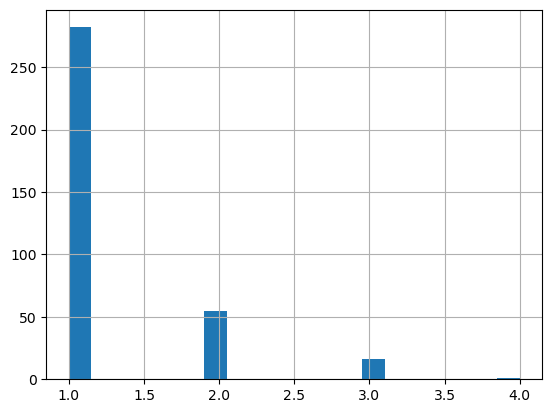

In [49]:
final_animations_index['repeat'].hist(bins=20)

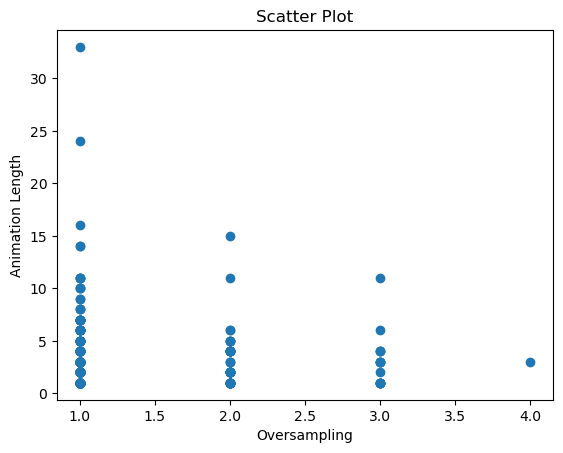

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['repeat']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Oversampling')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [51]:
final_animations_index[final_animations_index['filename'] == 'logo_2']

,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a17,a18,a19,a20,a21,a22,a23,a24,a25,repeat
74,logo_2,logo_2,5,0.0,0.0,2.0,0.0,2.0,0.0,0.0,...,1122.0,-13.0,20.0,562.0,590.0,596.0,143.999281,228.0,0.0,2


### Merge logo stats

In [52]:
logos.head()

,filename,count,count_category
0,logo_0,3,Quantile 2
1,logo_1,5,Quantile 8
2,logo_10,7,Quantile 12
3,logo_100,3,Quantile 2
4,logo_1000,4,Quantile 5


In [53]:
final_animations_index = final_animations_index.merge(logos[["filename","count"]], on='filename', how='left')
final_animations_index.rename(columns={'count': 'num_paths'}, inplace=True)
final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")
final_animations_index

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\1313802563.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  final_animations_index["file"] = final_animations_index["file"].str.replace(".svg","")


,filename,file,animation_length,a0,a1,a2,a3,a4,a5,a6,...,a18,a19,a20,a21,a22,a23,a24,a25,repeat,num_paths
0,logo_0,logo_0,3,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0,2,3.0
1,logo_1010,logo_1010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-7.0,12.0,233.0,230.0,40.0,56.085487,56.0,0.0,1,5.0
2,logo_1011,logo_1011,2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-31.0,-4.0,201.0,5.0,130.0,1.167170,43.0,0.0,1,4.0
3,logo_1037,logo_1037,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,11.0,26.0,697.0,765.0,705.0,132.111507,218.0,0.0,1,10.0
4,logo_104,logo_104,5,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,57.0,-52.0,103.0,74.0,264.0,40.763312,100.0,0.0,1,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,logo_92,logo_92,4,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,-45.0,-19.0,193.0,110.0,185.0,68.558913,73.0,0.0,2,7.0
350,logo_927,logo_927,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-9.0,-3.0,128.0,163.0,32.0,13.427724,67.0,0.0,2,2.0
351,logo_936,logo_936,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-13.0,-37.0,174.0,2.0,209.0,36.530171,77.0,0.0,2,2.0
352,logo_963,logo_963,5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,-24.0,34.0,89.0,97.0,54.0,0.168879,74.0,0.0,1,8.0


### Plot: Number of Paths vs Animation Length

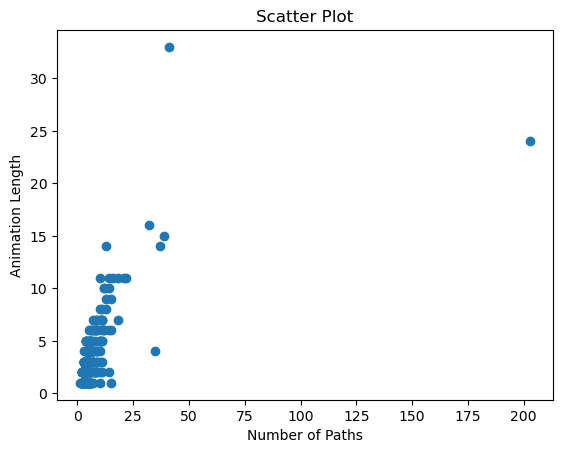

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the two columns for the scatter plot
x = final_animations_index['num_paths']
y = final_animations_index['animation_length']

# Create a scatter plot
plt.scatter(x, y)

# Add labels and a title
plt.xlabel('Number of Paths')
plt.ylabel('Animation Length')
plt.title('Scatter Plot')

# Show the plot
plt.show()

## Bucketing
For batching the data later on, build buckets to group animations with similar length characteristics

In [55]:
# from dataset_helper import generate_buckets_2D
# generate_buckets_2D(final_animations_index,
#                  'count',
#                  'animation_length',
#                  [0.2, 0.4, 0.6, 0.8, 1],
#                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Build Input Sequences Dictionary

In [56]:
def build_input_sequences_dict(sequences: pd.DataFrame, used_paths: pd.DataFrame, is_used_path_filtering = False, keep_unused=False):
    initial_length = len(sequences)
    used_paths['animation_id'] = used_paths['animation_id'].astype(str)
    if is_used_path_filtering:
        if keep_unused:
            # If keeping unused paths, perform a left merge and then filter where used paths are NaN
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id'], how='left', indicator=True)
            sequences = sequences[sequences['_merge'] == 'left_only'].drop(columns=['_merge']).copy()
            print(sequences)
            print(f"Filtering of input sequences to keep only unused paths. Reduction from {initial_length} to {len(sequences)} paths.")
        else:
            # If not keeping unused paths, perform an inner merge to keep only used paths
            sequences = pd.merge(sequences, used_paths, on=['filename', 'animation_id']).copy()
            #print(sequences, used_paths)
            print(f"Filtering of input sequences on only used paths. Reduction from {initial_length} to {len(sequences)} paths.")
    
    dict = {}
    for logo in sequences["filename"].unique():
        dict[logo] = sequences[sequences["filename"]==logo]
    #print(dict)
    return dict

In [57]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_used = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True)
print(input_sequences_dict_used.keys())
#input_sequences_dict_used[logos_train[0]]

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\4019560022.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


Filtering of input sequences on only used paths. Reduction from 47271 to 1064 paths.
dict_keys(['logo_2860', 'logo_3565', 'logo_3559', 'logo_2121', 'logo_1825', 'logo_1010', 'logo_908', 'logo_505', 'logo_3363', 'logo_2242', 'logo_1011', 'logo_3821', 'logo_2281', 'logo_2336', 'logo_2478', 'logo_896', 'logo_3941', 'logo_2849', 'logo_2685', 'logo_302', 'logo_2693', 'logo_24', 'logo_4745', 'logo_4023', 'logo_704', 'logo_1749', 'logo_2532', 'logo_506', 'logo_1576', 'logo_3361', 'logo_4630', 'logo_936', 'logo_4618', 'logo_2269', 'logo_3188', 'logo_3822', 'logo_2447', 'logo_856', 'logo_895', 'logo_4585', 'logo_1348', 'logo_3211', 'logo_107', 'logo_4973', 'logo_675', 'logo_1162', 'logo_3007', 'logo_4620', 'logo_4146', 'logo_4608', 'logo_4387', 'logo_4436', 'logo_3371', 'logo_4379', 'logo_2046', 'logo_927', 'logo_1177', 'logo_2442', 'logo_4999', 'logo_1836', 'logo_890', 'logo_4557', 'logo_310', 'logo_3789', 'logo_104', 'logo_1954', 'logo_3825', 'logo_4810', 'logo_4179', 'logo_4409', 'logo_1955'

In [58]:
input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")
input_sequences_dict_unused = build_input_sequences_dict(input_sequences, used_paths, is_used_path_filtering=True, keep_unused=True)
#input_sequences_dict_unused[logos_train[0]]

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\1504954084.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  input_sequences["filename"] = input_sequences["filename"].str.replace(".svg","")


      animation_id         0         1         2         3         4  \
2                3  0.141129  1.822560  0.397646  0.658561 -1.421428   
4                5 -0.157587  0.536932  0.361361 -0.021343 -0.385152   
5                4 -0.125373  1.281615 -0.026719  1.215896 -1.836534   
6                0 -1.479738  1.499942 -0.460764  0.363093 -0.947988   
7                1  0.813671  0.532380  1.347741  2.284749 -1.111322   
...            ...       ...       ...       ...       ...       ...   
47266            6 -0.187661  0.401433 -0.100404  0.636203 -0.474901   
47267            7  0.877559 -1.188825  1.372045 -0.126786 -0.186506   
47268            5 -0.833903  0.496440  0.277829  0.364739 -1.040107   
47269            4 -0.400199  0.921548  0.191972  0.333160 -1.018423   
47270            8  0.877559 -1.188825  1.372045 -0.126786 -0.186506   

              5         6         7         8  ...       247       248  \
2     -1.602260  0.216757  0.756272 -1.212852  ... -1.516084 

## Build Output Sequence (Embedded Paths with Animation Vector)

In [59]:
# Merge Dataframes
output_sequence = pd.merge(best_output, embeddings, on=['filename', 'animation_id'], how='inner')
animation_vectors=pd.DataFrame()
for i in range(26):
 animation_vectors[f'a{i}'] = output_sequence['model_output'].apply(lambda x: float(x.split(",")[i].replace("[","").replace("]","")))
#animation_vectors = pd.DataFrame(output_sequence["model_output"].to_list(), columns=["a1","a2","a3","a4","a5","a6","a7","a8","a9","a10","a11","a12"])
output_sequence.drop(['animation_id', 'model_output', 'label', 'rating', 'average_rating'], inplace=True, axis=1)
#output_sequence['a0'] = 0 # EOS Feature in One-hot Encoding
output_sequence = pd.merge(output_sequence, animation_vectors, left_index=True, right_index=True)
output_sequence["file"] = output_sequence["file"].str.replace(".svg","")

C:\Users\okan2\AppData\Local\Temp\ipykernel_27320\911588775.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  output_sequence["file"] = output_sequence["file"].str.replace(".svg","")


In [60]:
# Move column 'a13' to the back
column_to_move = 'a10'
new_order = [col for col in output_sequence.columns if col != column_to_move]
new_order.append(column_to_move)
#output_sequence = output_sequence[new_order]

In [61]:
output_sequence.head()

,Unnamed: 0,id,file,filename,0,1,2,3,4,5,...,a16,a17,a18,a19,a20,a21,a22,a23,a24,a25
0,0,0,logo_0,logo_0,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,2,0,logo_0,logo_0,-0.094627,1.475891,-0.203824,0.158015,-0.299620,0.895283,...,16.888462,18.0,29.0,45.0,99.0,9.0,185.0,7.297494,84.0,0.0
2,1022,5,logo_1509,logo_1509,0.888646,0.856151,0.463442,2.081298,-0.599237,-2.067103,...,9.863407,162.0,-9.0,-13.0,19.0,76.0,106.0,78.105163,70.0,0.0
3,1023,5,logo_1509,logo_1509,-0.178775,-0.420255,0.681953,0.106935,0.925431,-0.286306,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1024,5,logo_1509,logo_1509,-1.479738,1.499942,-0.460764,0.363093,-0.947988,-1.115443,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Main Iteration over all samples

In [62]:
from dataset_helper import generate_dataset


dataset = generate_dataset(final_animations_index,
                           input_sequences_dict_used,
                           input_sequences_dict_unused,
                           output_sequence,
                           {"train": logos_train, "test": logos_test},
                           sequence_length_input=100, # low as filtered
                           sequence_length_output=100, # input + SOS / EOS
                           )
# Executed in 1 minute with shortened padding ~Cornelius

Processing logo_0 with logo_0: 
Processing logo_1010 with logo_1010: 
Processing logo_1011 with logo_1011: 
Processing logo_1037 with logo_1037: 
Processing logo_104 with logo_104: 
Processing logo_1044 with logo_1044: 
Processing logo_107 with logo_107: 
Processing logo_108 with logo_108: 
Processing logo_1107 with logo_1107: 
Processing logo_1123 with logo_1123: 
Processing logo_1132 with logo_1132: 
Processing logo_1139 with logo_1139: 
Processing logo_1154 with logo_1154: 
Processing logo_1162 with logo_1162: 
Processing logo_1177 with logo_1177: 
Processing logo_1209 with logo_1209: 
Processing logo_1220 with logo_1220: 
Processing logo_1277 with logo_1277: 
Processing logo_1284 with logo_1284: 
Processing logo_1291 with logo_1291: 
Processing logo_1298 with logo_1298: 
Processing logo_13 with logo_13: 
Processing logo_1303 with logo_1303: 
Processing logo_1318 with logo_1318: 
Processing logo_1324 with logo_1324: 
Processing logo_1342 with logo_1342: 
Processing logo_1348 with lo

## Result

In [63]:
torch.save(dataset["train"]["input"], 'data/prototype_dataset/train_sequence_input.pt')
torch.save(dataset["train"]["output"], 'data/prototype_dataset/train_sequence_output.pt')
torch.save(dataset["test"]["input"], 'data/prototype_dataset/test_sequence_input.pt')
torch.save(dataset["test"]["output"], 'data/prototype_dataset/test_sequence_output.pt')

In [64]:
print(dataset["train"]["input"].size())
print(dataset["train"]["output"].size())
print(dataset["test"]["input"].size())
print(dataset["test"]["output"].size())

torch.Size([294, 100, 282])
torch.Size([294, 100, 282])
torch.Size([66, 100, 282])
torch.Size([66, 100, 282])
